## SeisSol Parameter Maker

A notebook for visualizing and setting up SeisSol simulation parameters

Written by Yair Franco, 2025

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

### SeisSol receiver generator

In [4]:
start = -75000 #in meters
end = 75000
step = 1000

coords = []

for y in range (start, end + 1, step):
    # coords.append(f'-15000 {y} 0')
    # coords.append(f'-7500 {y} 0')
    coords.append(f'0 {y} 0')
    # coords.append(f'7500 {y} 0')
    # coords.append(f'15000 {y} 0')


with open('coords.txt', 'w') as file:
    for c in coords:
        file.write(c + '\n')

### Nucleation patch depth calculator

Considering $d$, the down-dip depth of the center of the nucleation patch, and $l$, the length of the patch:

given fault dip $\delta$, the vertical depth of the top of the patch, $z_1$ is found by

## $\sin\delta = \frac{z_1}{d_{top}}$

### where $d_{top} = d - \frac{l}{2}$

so

## $z_1 = d_{top} \cdot \sin\delta$

and $z_2$, the bottom of the patch, is

## $z_2 = (d_{top} - l) \cdot \sin\delta$

In [5]:
def get_z(d,l,dip): # depth of centerpoint of patch and length of nuc patch
    dtop = - abs(d) + l/2 #calculate from top of patch
    z1 = dtop * np.sin(np.radians(dip))
    z2 = (dtop - l) * np.sin(np.radians(dip))
    return float(z2), float(z1)  #seissol defines z2 first for some reason

In [6]:
dip = 50
d = 12e3
l = 3e3

z1, z2 = get_z(d,l,dip)
print(f'z: [{z1}, {z2}]')

z: [-10341.599982106203, -8043.466652749269]


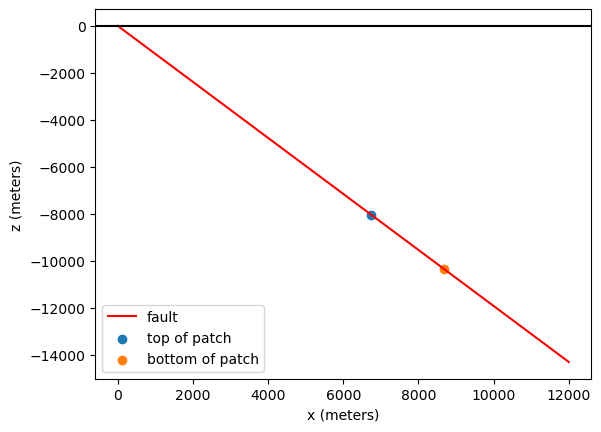

In [7]:
r = np.radians(dip)
x = np.linspace(1,12e3,100)
y = -np.tan(r) * x
x1, x2 = -z1 / np.tan(r), -z2 / np.tan(r)

plt.plot(x,y,c='red',label='fault')
plt.scatter(x2,z2,label='top of patch')
plt.scatter(x1,z1,label='bottom of patch')
plt.axhline(y=0,c='k')
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.legend()
plt.show()

### function for depth-dependent stress tensor components

In [8]:
def dd_stress(s1,s3,d):
    s1 = s1 * d
    s3 = s3 * d
    s2 = (s1 + s3) / 2
    return s1, s2, s3

In [9]:
s1 = 26460. #initial vector params
s3 = 15624.3
s2 = (s1 + s3)/2

S = np.array([s1,0,0,0,s2,0,0,0,s3])
S = S.reshape(3,3)

print(f'initial stress matrix: \n{S}')

v1 = np.array([-1,0,0])
v2 = np.array([0,-1,np.sqrt(3)])
# v2 = np.array([np.sqrt(3),0,0])

n = np.cross(v1,v2)
n1, n2, n3 = n[0], n[1], n[2]
norm = np.linalg.norm(n)
print(f'normal vector: [{n1}, {n2}, {n3}]')
nn = n / norm
nn1, nn2, nn3 = nn[0], nn[1], nn[2]
print(f'normalized fault plane vector: [{nn1}, {nn2}, {nn3}]')

T = np.matmul(S,nn)
T1, T2, T3 = T[0], T[1], T[2]
print(f'traction vector: {T}')
Tn = T / np.linalg.norm(T)

#deviatoric stress
Smean = round((s1+s2+s3) / 3,2)
d1, d2, d3 = s1 - Smean, s2 - Smean, s3 - Smean
print(f'mean stress: {Smean}')
D = np.array([d1,d2,d3])
print(f'deviatoric stress vector: {D}')
Dn = D / np.linalg.norm(D)
print(f'Norm. dev. vector: {Dn}')

a = np.arccos(np.dot(nn,Tn)) #angle between fault normal and traction vector
b = np.arccos(np.dot(nn,Dn)) #angle between fault normal and deviatoric stress

print(f'angle between normal and traction: {round(np.degrees(a),2)}°')
print(f'angle between normal and deviatoric stress: {round(np.degrees(b),2)}°')

initial stress matrix: 
[[26460.       0.       0.  ]
 [    0.   21042.15     0.  ]
 [    0.       0.   15624.3 ]]
normal vector: [0.0, 1.7320508075688772, 1.0]
normalized fault plane vector: [0.0, 0.8660254037844387, 0.5000000000000001]
traction vector: [    0.         18223.03645024  7812.15      ]
mean stress: 21042.15
deviatoric stress vector: [ 5417.85     0.   -5417.85]
Norm. dev. vector: [ 0.70710678  0.         -0.70710678]
angle between normal and traction: 6.8°
angle between normal and deviatoric stress: 110.7°


Plotting stress tensors as vectors

Text(0.5, 0.92, 'Stress vectors for SeisSol TPV12 simulation')

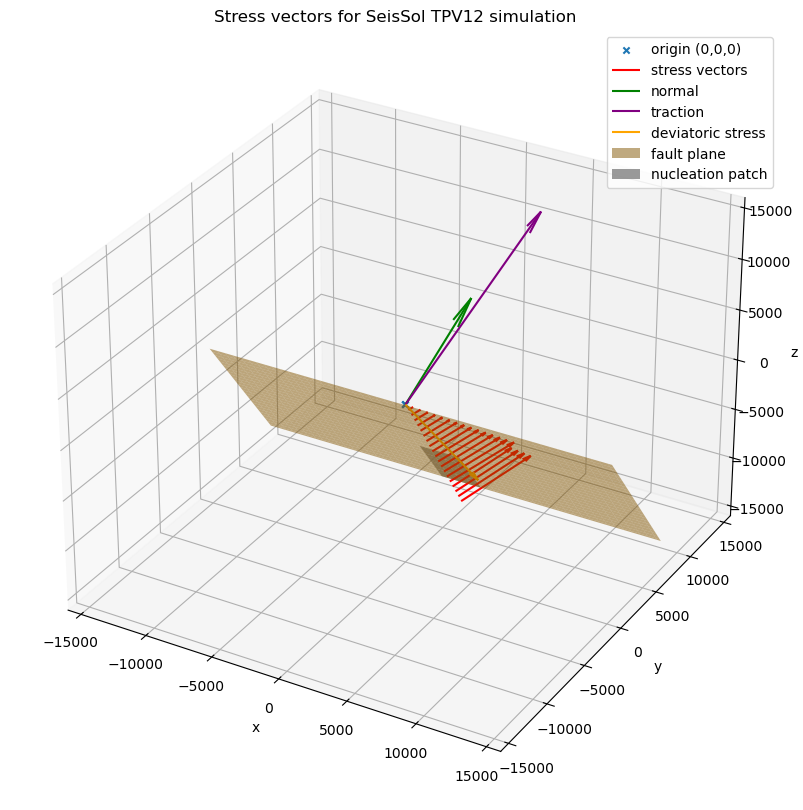

In [10]:
# %matplotlib osx

ax = plt.figure(figsize=[14,10]).add_subplot(projection='3d')

d = np.linspace(0,-15000,20) #depth dependent vector params
iso_lim = -11951.15 #stress is anisotropic above this depth
stress = np.where(d < iso_lim, dd_stress(s1,s2,-d), 26460*-d)
ud, vd, wd = stress[0], stress[1], stress[2]

s = np.array([s1,s2,s3])

o = [0,0,0]
n_s = s / np.sqrt(np.dot(s,s)) #normalize vector

x0, y0, z0 = o[0], o[1], o[2]
u, v, w = n_s[0], n_s[1], n_s[2]

lf = 30e3 #fault plane params
wf = 15e3
dip = 60.
dip_rad = np.radians(dip)

fx = np.linspace(x0 - lf/2, x0 + lf/2, 100) #create plane
fy = np.linspace(y0 - wf/2, y0 + wf/2, 100)
fx, fy = np.meshgrid(fx, fy)
fz = z0 - (fy - y0) * np.tan(dip_rad)
fz = np.where(fz <= 0, fz, np.nan) #fault plane is only below ground (z<0)

nl = 3e3 #nucleation patch params
nw = 3e3
n_depth = -12e3 #how deep into the fault plane is the patch
nx0 = 0
ny0 = -n_depth * np.cos(dip_rad) #dip is shared with fault plane
nz0 = n_depth * np.sin(dip_rad)

nx = np.linspace(nx0 - nl/2, nx0 + nl/2, 5)
ny = np.linspace(ny0 - nw/2, ny0 + nw/2, 5)
nx, ny = np.meshgrid(nx, ny)
nz = nz0 - (ny - ny0) * np.tan(dip_rad)


ax.scatter(o,ys=0,marker='x',label='origin (0,0,0)') #plot everything
# ax.quiver(x0,y0,z0,u,v,w,length=1e4,arrow_length_ratio=0.1,color='red',label='initial stress vector')
ax.quiver(x0,-d*np.cos(dip_rad),d,vd,wd,ud,length=1e-5,arrow_length_ratio=0.1,color='red',label='stress vectors')
ax.quiver(x0,y0,z0,n1,n2,n3,length=5000,arrow_length_ratio=0.25,color='green',label='normal')
ax.quiver(x0,y0,z0,T1,T2,T3,length=1,arrow_length_ratio=0.1,color='purple',label='traction')
ax.quiver(x0,y0,z0,d1,d2,d3,length=1,arrow_length_ratio=0.1,color='orange',label='deviatoric stress')
ax.plot_surface(fx,fy,fz,color='orange',label='fault plane', alpha=0.5)
ax.plot_surface(nx,ny,nz,color='white',label='nucleation patch', alpha = 0.8)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_lims = [-16e3,16e3]
y_lims = [-16e3,16e3]
z_lims = [-16e3,16e3]
ax.set(**{'xlim3d': x_lims,
          'ylim3d': y_lims,
          'zlim3d': z_lims})

ax.legend()
# ax.view_init(azim=10,elev=10)
ax.set_title(f'Stress vectors for SeisSol TPV12 simulation')

# for angle in range(0, 360): # run this loop to see a cool animation! (uncomment '%matplotlib osx')
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

#### From Scholz text:

The stress condition for fault slip on a fault inclined at an angle $\theta_R$ to $\sigma_1$ (maximum stress) is defined by

# $\frac{\sigma_1 - p}{\sigma_3 - p} = \frac{1 + \mu \cot{\theta_R}}{1 - \mu \tan{\theta_R}}$

where $p$ is the pore pressure and $\mu$ is the static friction coefficient.

(since $\sigma_1$ for normal slip is vertical, $\theta_R$ and dip are complementary, and $\theta_R = 90° - \delta$, where $\theta_R$ is the most favorable angle for slip)

#### The [TPV12-13 experiment description](https://strike.scec.org/cvws/download/TPV12_13_Description_v6.pdf) defines $\sigma_3$ as

## $(\sigma_3 - P_f) = 0.3496(\sigma_1 - P_f)$

#### where $P_f = 1000 \frac{kg}{m^3} \times 9.8 \frac{m}{s^2} \times H $, the fluid pressure at depth $H$.

which suggests that the constant is obtained from the term
## $\frac{1 + \mu \cot{\theta_R}}{1 - \mu \tan{\theta_R}}$

In [11]:
mu = 0.54
a = np.arctan(mu)
print(a)
theta_s = a/2 + np.pi/2
np.tan(theta_s)**2

0.49513326346840414


np.float64(15.653537802565374)

In [12]:
def slip_constant(mu,theta_r):
    tt = np.tan(theta_r)
    return (1 + (mu * (1/tt))) / (1 - (mu * tt))

In [13]:
theta_r = np.radians(90-dip)
mu = 0.54 #as TPV12-13 description

const = 1 / slip_constant(mu,theta_r) #inverted due to s1 being on the right side
trueconst = 1 / slip_constant(0.55,theta_r)

print(f'mu = {mu}, {round(const,5)} is within {round(100*(const/0.3496-1),2)}% of the given 0.3496...but not exact. {round(const-0.3496,5)} away')
print(f'However, with mu = 0.55, {round(trueconst,4)} is within {abs(round(100*(trueconst/0.3496-1),2))}%')

mu = 0.54, 0.35562 is within 1.72% of the given 0.3496...but not exact. 0.00602 away
However, with mu = 0.55, 0.3495 is within 0.03%


In [14]:
dip = 50
theta_r = np.radians(90-dip)
const = 1 / slip_constant(mu,theta_r) #inverted due to s1 being on the right side

print(f'mu = {mu}, dip = {dip}, constant = {const}')

mu = 0.54, dip = 50, constant = 0.3327475387858276


In [15]:
q = (np.sqrt((mu ** 2) + 1) + mu) ** 2
qq = (1 + np.sin(theta_r)) / (1 - np.sin(theta_r))
print(1/q)
print(1/qq)

0.35579532345684783
0.21744283205399909


how do we reach 2.860411899313501 by reverse engineering
with this formula, we need mu to equal 0.55, which is 0.0% off


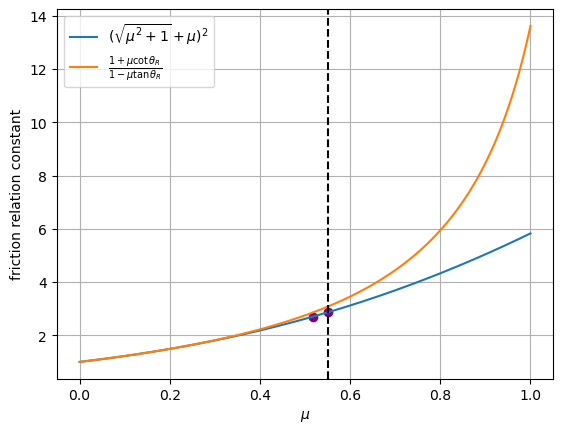

In [16]:
constinv = 1/0.3496
print(f'how do we reach {constinv} by reverse engineering')
x = np.linspace(0,1,1001) #values of mu
y = (np.sqrt((x ** 2) + 1) + x) ** 2
y2 = slip_constant(x,theta_r)
matchi = np.abs(y-constinv).argmin()
match2i = np.abs(y2-constinv).argmin()
print(f'with this formula, we need mu to equal {(x[matchi])}, which is {abs(round(100*(y[matchi]/constinv-1),3))}% off')
labels = [r'$(\sqrt{\mu^2 + 1} + \mu)^2$',r'$\frac{1 + \mu \cot{\theta_R}}{1 - \mu \tan{\theta_R}}$']
plt.plot(x,y,label=labels[0])
plt.plot(x,y2,label=labels[1])
plt.axvline(x[matchi],c='k',ls='--')
plt.scatter(x[matchi],y[matchi],c='purple')
plt.scatter(x[match2i],y[match2i],c='purple')

plt.xlabel(r'$\mu$')
plt.ylabel(f'friction relation constant')
plt.legend()
plt.grid()
plt.show()

#### From Jaeger, Cook & Zimmerman textbook:

# $\sigma_1 = 2S_o \tan{\beta} + \sigma_3 \tan{^2\beta}$,

where $S_o$ is the cohesion (sometimes denoted as $c$) and $\beta$ is the angle between the plane normal and $\sigma_1$.

This means $\beta = 90° - \delta$ for normal slip and $\beta = \delta$ for reverse slip, where $\delta$ is the dip of the rupture plane.

In this case, $\sigma_1$ is simply the overburden stress, defined similar to before:

### $\sigma_1 = P_f = 2700 \frac{kg}{m^3} \times 9.8 \frac{m}{s^2} \times H $
at depth $H$.

Solving for $\sigma_3$ gives

# $\sigma_3 = \frac{\sigma_1 - 2S_o}{\tan{\beta}}$

In [17]:
def s1_s3(dip,mech,z,c=0,rho=2700,g=9.8):
    s1 = rho * g * z #overburden pressure

    if mech in ('n','N','NS','normal'):
        b = 90 - dip
    elif mech in ('r','R','RS','reverse','thrust'):
        b = dip

    s3 = (s1 - 2 * c) / np.tan(np.radians(b))
    return s1,s3

def calc_q(dip,mech,c=0):
    if mech in ('n','N','NS','normal'):
        b = 90 - dip
    elif mech in ('r','R','RS','reverse','thrust'):
        b = dip

    q = (2 * c * np.tan(b)) + ((np.tan(b)) ** 2)
    return q

0.3496
98 0.6813989043463924
[-4.08970609e-02 -8.80297806e-02 -1.42942001e-01 -2.07733045e-01
 -2.85332240e-01 -3.79954107e-01 -4.97890012e-01 -6.48967210e-01
 -8.49438979e-01 -1.12826352e+00 -1.54253322e+00 -2.22260254e+00
 -3.54510792e+00 -7.23523795e+00 -7.39194587e+01  1.04634850e+01
  5.21284019e+00  3.60488183e+00  2.82516132e+00  2.36481240e+00
  2.06096910e+00  1.84541587e+00  1.68455186e+00  1.55990689e+00
  1.46048644e+00  1.37933703e+00  1.31184587e+00  1.25483240e+00
  1.20603244e+00  1.16379036e+00  1.12686749e+00  1.09431863e+00
  1.06541001e+00  1.03956328e+00  1.01631645e+00  9.95296027e-01
  9.76196782e-01  9.58766844e-01  9.42796526e-01  9.28109849e-01
  9.14558031e-01  9.02014426e-01  8.90370557e-01  8.79532971e-01
  8.69420723e-01  8.59963353e-01  8.51099241e-01  8.42774262e-01
  8.34940681e-01  8.27556236e-01  8.20583378e-01  8.13988629e-01
  8.07742044e-01  8.01816763e-01  7.96188616e-01  7.90835800e-01
  7.85738593e-01  7.80879112e-01  7.76241107e-01  7.71809774e

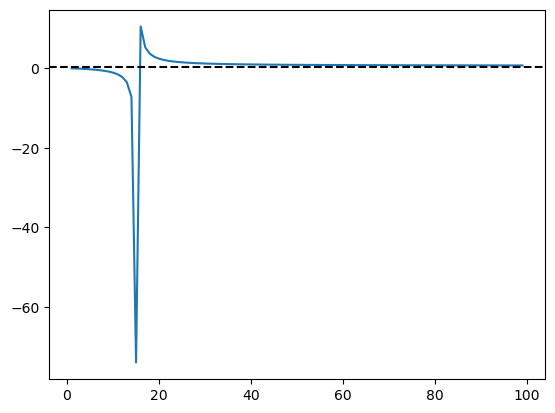

In [18]:
h = np.arange(1,100,1)
s1, s3 = s1_s3(60,'n',h,c=0.2e6)
q = calc_q(60,'n')

aa = s1/s3
exacti = np.abs(aa-(1/constinv)).argmin()
coinc = aa[exacti]
print(1/constinv)
print(exacti,coinc)
plt.plot(h,aa)
plt.axhline(1/constinv,c='k',ls='--')
# plt.plot(h,s1/1e6)
# plt.plot(h,s3/1e6)
# plt.ylim(0,2)
print(aa)

In [19]:
1/0.3496

2.860411899313501

In [20]:
def material_Vs(mu,rho):
    return np.sqrt(mu/rho)

def material_Vp(K,mu,rho):
    return np.sqrt((K + ((4/3)*mu)) / rho)

In [21]:
rho = 2700 #density
mu = 2.9403e+010 #lame parameters
l = 2.941e+010
K = l + 2/3 * mu #bulk modulus

print(f'S wave speed: {material_Vs(mu,rho)} m/s')
print(f'P wave speed: {material_Vp(K,mu,rho):.1f} m/s')


S wave speed: 3300.0 m/s
P wave speed: 5716.0 m/s


Traction to stress for SeisSol input

Given:

fault-normal shear stress: 7378 Pa/m x down-dip depth

dip-direction shear stress: 0.55 x initial notmal stress

assuming stress tensor must be rotated only about y-axis (fault is normal to x, and no fault-parallel stress, so this direction doesn't matter), we rotate about y-axis (this has to be exchanged for x-axis for SeisSol training set)

In [ ]:
def trac2stress(T_d,T_n,T_s,dip):
    #normal stresses
    sxx = T_s
    syy = -T_n
    szz = 0

    #shear stresses
    sxy = 0
    syz = T_d
    szx = 0

    #apply dip (subtracted from horizontal 90°)
    thetax = np.radians(dip)
    thetay = np.radians(0)
    thetaz = np.radians(0)

    #traction tensor
    A = np.array([[sxx,sxy,szx],
                 [sxy,syy,syz],
                 [szx,syz,szz]])
    
    #tensor for x-axis rotation
    Tx = np.array([[1,       0,             0         ],
                  [0, np.cos(thetax), -np.sin(thetax)],
                  [0, np.sin(thetax), np.cos(thetax) ]])
    
     #tensor for y-axis rotation
    Ty = np.array([[np.cos(thetay), 0, np.sin(thetay)],
                  [0,              1,         0      ],
                  [-np.sin(thetay), 0, np.cos(thetay) ]])
    
    #tensor for z-axis rotation
    Tz =  np.array([[np.cos(thetaz), -np.sin(thetaz), 0],
                  [np.sin(thetaz), np.cos(thetaz), 0 ],
                  [0,                   0,         1 ]])
    
    #rotate to global coordinates
#     A_tempx = np.matmul(np.matmul(Tx,A),Tx)
#     A_tempy = np.matmul(np.matmul(Ty,A_tempx),Ty)
#     stress_global = np.matmul(np.matmul(Tz,A_tempy),Tz)

    A_tempx = Tx @ A @ Tx
    A_tempy = Ty @ A_tempx @ Ty
    stress_global = Tz @ A_tempy @ Tz

    #print(f'[sxx,sxy,sxz],\n[sxy,syy,syz],\n[sxz,syz,szz]')
    return stress_global

In [113]:
T_n = 7378
T_d = 0.55 * T_n
T_s = 0
dip = 30

correct_stress = np.array([[0,0,0],
                          [0,-2019.26,5223.72],
                          [0,5223.73,-5358.74]])
print(correct_stress)
# print(f'[0,0,0],\n[0,-2019.26,5223.72],\n[0,5223.73,-5358.74]')
trac2stress(T_d,T_n,T_s,dip)

[[    0.       0.       0.  ]
 [    0.   -2019.26  5223.72]
 [    0.    5223.73 -5358.74]]


array([[    0.        ,     0.        ,     0.        ],
       [    0.        , -1844.5       ,  7252.66771456],
       [    0.        ,   863.13228544,  5533.5       ]])

1.0709981966691418

In [52]:
t_n = 12000 * np.sin(np.deg2rad(60)) * 7378

In [61]:
tnuc_d = (0.760 + 0.0057) * t_n + 200000
t_d = 0.55 * t_n
print(t_n)
print(tnuc_d)
print(10e6)

76674425.14945906
58909607.33694081
10000000.0


In [59]:
tnuc_d - t_d

np.float64(16738673.504738323)

In [63]:
"%.2e" % t_d

'4.22e+07'